In [229]:
#============================================================================================================
# class Screen
# usage: scr = Screen(m,n,s,d)         # create Screen instance
#        P = np.random.rand(s,d)       # permanences
#        Q = (P >= 0.5)                # synaptics
#        scr.plot((i,j),x,y,P,Q)
#============================================================================================================

from carabao.screen import Canvas

class Screen:
    def __init__(self,tag,m=None,n=None,s=None,d=None):
        m = m if m != None else 4
        n = n if n != None else 10
        s = s if s != None else 5
        d = d if d != None else 2

        self.tag = tag
        self.m = m;  self.n = n;  self.s = s;  self.d = d
        self.ij = (0,0)
        self.setup()
        self.cls()

    def cls(self):           # clear screen
        self.can = Canvas([0,0,self.n+1,self.m+2])
        return self.can

    def setup(self):
        self.r0 = 0.45;  self.r1 = 0.38;  self.r2 = 0.31
        self.ds = 0.11; self.rs = self.ds/3;
        self.gray = (0.8,0.8,0.8);  self.red = (1,0,0)
        self.gold = (1,0.9,0);      self.dark = (0.5,0.5,0.5)
        self.blue = (0,0.5,1);      self.green=(0,0.8,0)
        self.magenta = (1,0.2,1)

    def segment(self,x,y,r,d,mu,col):  # plot mu-th dendritic segment out of total d
        H = r*0.9;  W = 2*r            # total height/width of all segments
        yoff = r*0.2                   # y offset of segments
        h = H/d; w = W/2               # height and half width of segment
        dy = r/4
        ymu = y + yoff - mu*h          # top position of mu-th segment
        self.can.fancy((x-w,ymu-h),(x+w,ymu),col,r=r/10)

    
    def neuron(self,ij,x=None,y=None,P=None,Q=None,L=None):
        x = x if x else 0
        y = y if y else 0

        P = P if P != None else np.random.rand(self.d,self.s)
        Q = Q if Q != None else P*0    # permanence matrix
        L = L if L != None else P*0    # learning matrix

        outer = self.red if y>0 else self.gray
        inner = self.green if x>0 else self.dark
        core  = self.gold if L.any().any() else self.gray

        #print("y:",y,", outer:",outer)
        #print("x:",x,", inner:",inner)
        #print("P:\n",P)
        #print("Q:\n",Q)

        i = ij[0];  j = ij[1]
        x = 1+j; y = self.m+1-i;

        r0 = self.r0;  r2 = self.r2
        #self.can.fancy((0.3,0.6),(0.7,1.0),'r',r=0.05,angle=45,center=((.7,.7)))
        
        
        self.can.circle((x,y),self.r0,outer)
        self.can.circle((x,y),self.r1,inner)
        self.can.circle((x,y),self.r2,core)
        self.can.fancy((x-r2,y-r2),(x+r2,y+r2),'r',r=0.05,angle=45,center=(0,0))

           # draw dentritic segments

        d = self.d+1
        for mu in range(0,d):
            self.segment(x,y,self.r0,d,mu,self.gray)

        d0 = self.d-1;  s0 = self.s-1
        for mu in range(0,self.d):
            for nu in range(0,self.s):
                xx = x + self.ds*(nu-s0/2);
                yy = y + self.ds*(d0-mu-d0/2)
                if L[mu,nu] > 0 and P[mu,nu] < 0.5:
                    col = self.red
                elif L[mu,nu] > 0 and P[mu,nu] >= 0.5:
                    col = self.green
                elif Q[mu,nu] > 0:
                    col = self.magenta
                elif L[mu,nu] > 0 and P[mu,nu] < 0.5:
                    col = 'b'
                else:
                    col = 'w' if P[mu,nu] >= 0.5 else 'k'
                self.can.circle((xx,yy),self.rs,col)

    def cell(self,ij,x=None,y=None,P=None,Q=None,L=None):
        x = x if x else 0
        y = y if y else 0

        P = P if P != None else np.random.rand(self.d,self.s)
        Q = Q if Q != None else P*0    # permanence matrix
        L = L if L != None else P*0    # learning matrix

        outer = self.red if y>0 else self.gray
        inner = self.green if x>0 else self.dark
        core  = self.gold if L.any().any() else self.gray

        #print("y:",y,", outer:",outer)
        #print("x:",x,", inner:",inner)
        #print("P:\n",P)
        #print("Q:\n",Q)

        i = ij[0];  j = ij[1]
        x = 1+j; y = self.m+1-i;
        self.can.circle((x,y),self.r0,outer)
        self.can.circle((x,y),self.r1,inner)
        self.can.circle((x,y),self.r2,core)

        d0 = self.d-1;  s0 = self.s-1
        for mu in range(0,self.d):
            for nu in range(0,self.s):
                xx = x + self.ds*(nu-s0/2);
                yy = y + self.ds*(d0-mu-d0/2)
                if L[mu,nu] > 0 and P[mu,nu] < 0.5:
                    col = self.red
                elif L[mu,nu] > 0 and P[mu,nu] >= 0.5:
                    col = self.green
                elif Q[mu,nu] > 0:
                    col = self.magenta
                elif L[mu,nu] > 0 and P[mu,nu] < 0.5:
                    col = 'b'
                else:
                    col = 'w' if P[mu,nu] >= 0.5 else 'k'
                self.can.circle((xx,yy),self.rs,col)

    def input(self,j,u):
        u = u if u != None else 1
        x = 1+j; y = 1;
        col = self.blue if u > 0 else self.gray
        self.can.circle((x,y),self.r2,col)

    def at(self,i,j):  # to tell a Cell constructor where to place a cell
        self.ij = (i,j)
        return self

    def show(self):
        plt.show()

#=============================================================================
# class Monitor
# usage: mon = Monitor(4,10)
#        cell = Cell(mon,k,g,K,P)
#        cell.show()
#=============================================================================

#from carabao.screen import Screen
import torch
import numpy

class Monitor:
    def __init__(self,m,n,verbose=0):
        self.screen = Screen('Neurons',m,n)
        self.ij = (0,0)
        self.verbose = verbose
        self.iteration = 0
        self.phase = None
 
            # recorder init

        self.initrecorder()
 
    def initrecorder(self):
        nan = float('nan');

        self._x = nan
        self._y = nan
        self._P = None
        self.x_ = None
        self.P_ = None

        self.b = nan            # at this phase no burst signal needed
        self.s = nan            # dendritic spike
        self.p = nan            # at this phase no post s. effect needed
        self.q = nan 
        self.l = nan            # at this phase no learning vector needed
        self.y_ = nan

        self.W = None           # no weights needed
        self.Z = None           # no pre-synaptic signals needed
        self.Q = None           # no synaptics
        self.L = None           # no binary learning matrix
        self.D = None           # no binary learning matrix

    def place(self,screen,ij):
        self.screen = screen
        self.ij = ij

    def at(self,screen):
        if screen != None:
            self.place(screen,screen.ij)

    def plot(self,cell,i=None,j=None):
        if i != None:
            self.place(self.screen,(i,j))
 
        self.screen.cell(self.ij,cell.x,cell.y,cell.P,self.Q,self.L)
        self.screen.input(self.ij[1],cell.u)
        self.screen.show

    def record(self,x_,P_):
        self.x_ = x_
        self.P_ = P_
    
    def log(self,cell,msg=None,phase=None):
        nan = float('nan')
        msg = msg if msg != None else ""
        self.phase = phase if phase != None else self.phase
        print("-------------------------------------------------------------")
        print("iteration: ",self.iteration,msg)
        print("   k:",cell.k,", g:",cell.g,", eta:",cell.eta)
        self.print('matrix',"   K:",cell.K)
        self.print('matrix',"   P:",cell.P)
        if (self.phase == 2):
            self.print('matrix',"   W:",self.W)
            self.print('matrix',"   Z:",self.Z)
            self.print('matrix',"   Q:",self.Q)
            self.print('matrix',"   L:",self.L)
            self.print('matrix',"   D:",self.D)
            print("   b:",self.b,", q:",self.q,
              " (||q||=%g)" % (nan if numpy.isnan(self.q).any() else sum(self.q)))
            print("   l:",self.l,", p:",self.p,
              "(||Q||=max(l)=%g, theta:%g)" % (cell.norm(self.Q),cell.theta))
        print("   u:",cell.u)
        print("   x: %g (was: %g)" % (cell.x,self._x))
        print("   y: %g (was: %g)" % (cell.y,self._y))
        print("   c:",cell.c)
        print("-------------------------------------------------------------")

        if (phase == 2):
            #self.invalid(cell,'b,p,l,W,Z')       # invalidate
            self.iteration += 1

    def print(self,tag,msg,arg):   # .print("matrix","Q:",Q)
        if tag == 'matrix':
            m,n = arg.size()
            print(msg,"[",end='')
            sepi = ''
            for i in range(0,m):
                print(sepi,end='');  sepi = '; ';  sepj = ''
                for j in range(0,n):
                    s = "%4g" % arg[i,j].item()
                    s = s if s[0:2] != '0.' else s[1:]
                    s = s if s[0:3] != '-0.' else '-'+s[2:]
                    print("%5s" % s, end=''); 
                    sepj = ' '
            print(']')
        elif tag == 'number':
            print(msg,"%4g" % arg)
        
    def show(self,i=None,j=None):
        if i != None:
            self.plot(i,j)
        can = self.neurons.canvas()
        self.plot()

 

#=============================================================================
# class Cell
# usage: scr = Screen('Neurons',4,10)
#        cell = Cell(scr.at(1,2),k,g,K,P)
#        cell.show()
#=============================================================================

#from carabao.screen import Screen
import torch
import numpy

class Cell:
    def __init__(self,mon,k,g,K,P):
        self.mon = mon
        self.x = 0             # x(0), or in general: x(t+1)
        self.P = P             # P(0), or in general: P(t+1)
        self.y = float('nan')  # cell output (axon)
        self.u = float('nan')  # feedforward input
        self.c = float('nan')  # context input
        self.config(k,g,K,P)
        
    def config(self,k,g,K,P):
        self.eta = 0.5      # synaptic threshold
        self.theta = 2      # dendritic threshold
        self.pdelta = 0.04  # positive learning delata
        self.ndelta = 0.02  # negative learning delta
        self.k = k;
        self.g = g;  
        self.K = K;
        
    def input(self,u,c):                # update input

            # excited (u=1) & predictive (x=1) cells get active (y=1)
        
        self.u = u                 
        self.y = self.u * self.x   # excited & predictive cells get active

            # update context c[k] with updated output y
        
        c[self.k] = self.y         # update context with changed output
        self.c = c                 # store c in cell

            # log key quantities (if verbose)

        mon.log(self,'(input)',phase=1)
        return self.c                  # return updated context
        
    def context(self,c):               # process context
        self.c = c
        
            # excited bursting cells get active (second chance) 
        
        b = self.burst(c)
        self.y = self.u * (self.y if b == 0 else 1)
        c[self.k] = self.y             # update context

            # process W,Z,Q,L
        
        W = (self.P >= self.eta)       # synaptic (binary) weights
        Z = self.select(c,self.K)      # pre-synaptic signals
        Q = torch.mul(Z,W)             # synapitcs matrix
  
            # spiking cells get predictive (calculate state after transition)

        s = (self.norm(Q) >= self.theta) # dentritic spike 
        x_ = self.u * s                # getting predictive

            # spiking cells learn (calculate permanences after transition)

        L,l,p = self.learn(Q)
        D = self.y * (L*Q*self.pdelta - L*self.ndelta)
        P_ = self.P + D                # learning (permanences after transition)

            # save this stuff

        mon.x_ = x_;  mon.P_ = P_
        mon.L = L;  mon.D = D;  mon.Q = Q;  mon.l = l;  mon.p = p;
        mon.b = b;  mon.W = W;  mon.Z = Z
        mon.record(x_,P_)
        mon._x = self.x                # save x(t) in history x(t-1)
        mon._y = self.y               # save y(t) in history y(t-1)
        mon.b = b;  mon.s = s;
        
        self.transition(x_,P_)
        mon.log(self,"(context)",phase=2)
        return c

    def select(self,c,K):
        self.Z = 0*K
        for mu in range(0,K.size(0)):
            for nu in range(0,K.size(1)):
                self.Z[mu,nu] = c[K[mu,nu]];
        return self.Z

    def norm(self,M):    # max of column sums
        result = 0
        for j in range(0,M.size(0)):
            sumj = M[j].sum().item()
            result = result if sumj < result else sumj
        return result
            
    def transition(self,x_,P_):        # state & permanence transition
        self.x = x_                    # state transition
        self.P = P_                    # permanence transition

        self.x_ = float('nan')         # invalidate
        self.P_ = float('nan')         # invalidate

    def burst(self,c):
        self.q = []
        for k in range(0,len(self.g)):
           qk = c[self.g[k]]
           self.q.append(qk)
        b = (sum(self.q) == 0)               # burst signal
        return int(b)

    def learn(self,Q):                       # learning vector
        d,s = Q.size()
        l = [];  p = []
        for mu in range(0,d):
            norm = sum(Q[mu]).item()
            l.append(norm)
            p.append(int(norm >= self.theta))
        L = torch.tensor([p]).t()*torch.ones(1,s)
        return L,l,p

    def plot(self,i=None,j=None):
        mon.plot(self,i,j)
        
       


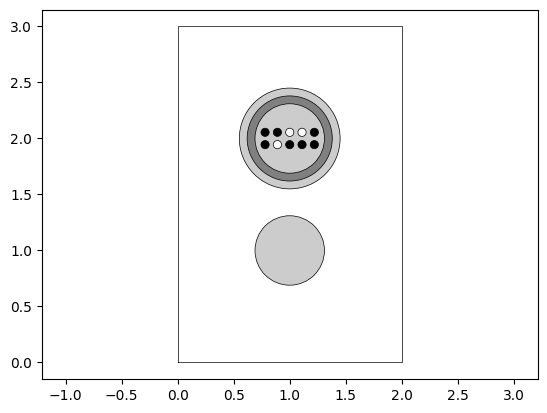

In [230]:
# Test Monitor

k = 0                        # cell index
g = [0,1,2,3]                # group indices
K = torch.tensor([[1,3,5,7,9],[3,4,5,6,7]])
P = torch.tensor([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])

    # create an inactive neuron

mon = Monitor(1,1)
cell = Cell(mon,k,g,K,P)
cell.plot(0,0)

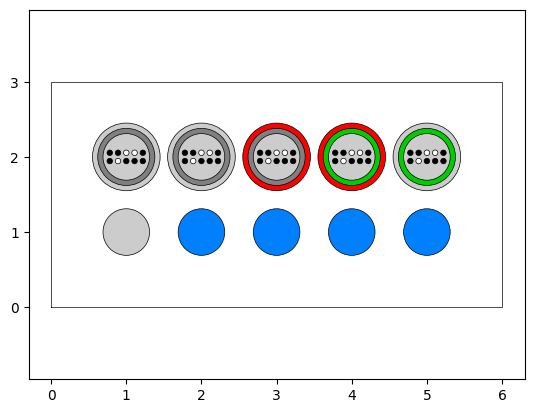

In [231]:
# Setup a cell

g = [0,1,2,3]                # group indices
K = torch.tensor([[1,3,5,7,9],[3,4,5,6,7]])
P = torch.tensor([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])

    # create an inactive neuron

mon = Monitor(1,5)
cell = Cell(mon,0,g,K,P)
cell.plot()

    # cell excitation

cell.u = 1
cell.plot(0,1)

    # cell activation

cell.y = 1
cell.plot(0,2)

    # predictive state activation

cell.x = 1
cell.plot(0,3)

    # cell deactivation

cell.y = 0
cell.plot(0,4)




-------------------------------------------------------------
iteration:  0 (configured)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: nan
   x: 0 (was: nan)
   y: nan (was: nan)
   c: nan
-------------------------------------------------------------


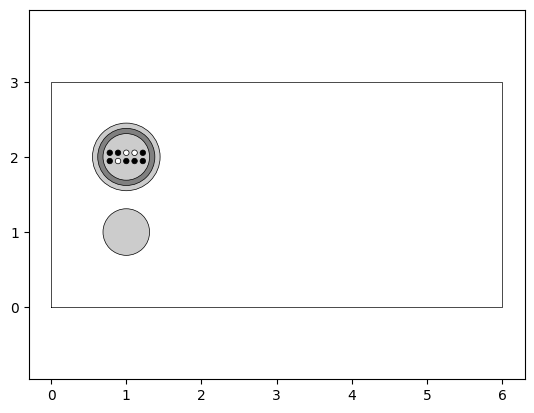

In [232]:
# step 1: create an inactive neuron

g = [0,1,2,3]                # group indices
K = torch.tensor([[1,3,5,7,9],[3,4,5,6,7]])
P = torch.tensor([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])

    # create an inactive neuron

mon = Monitor(1,5)
cell = Cell(mon,0,g,K,P)
c = [0,0,0,0,1,1,1,1,0,1]    # context

cell.verbose = 1
mon.log(cell,"(configured)")
cell.plot()

-------------------------------------------------------------
iteration:  0 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: 1
   x: 0 (was: nan)
   y: 0 (was: nan)
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


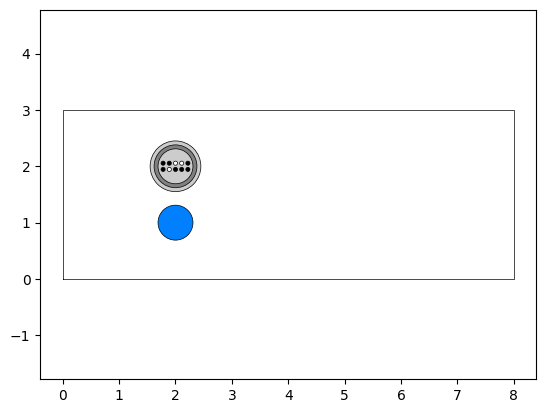

In [233]:
# step 2 / iteration 0: apply input u(0) to neuron

mon = Monitor(1,7);  cell.mon = mon
c = cell.input(1,c)
cell.plot(0,1)

-------------------------------------------------------------
iteration:  0 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 1 , q: nan  (||q||=nan)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 0)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


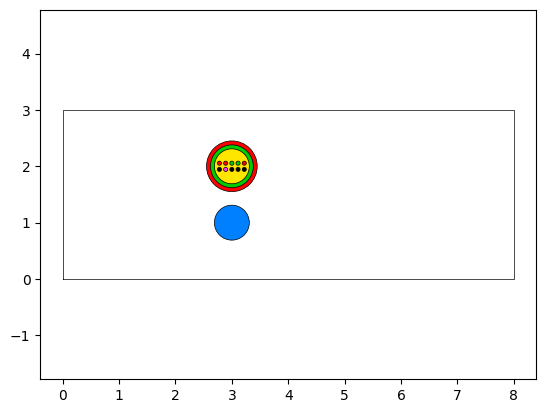

In [234]:
# step 3 / iteration 0: apply context c(0) to neuron

mon = Monitor(1,7);  cell.mon = mon
c = cell.context(c)
cell.plot(0,2)

-------------------------------------------------------------
iteration:  0 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   u: 1
   x: 1 (was: nan)
   y: 1 (was: nan)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


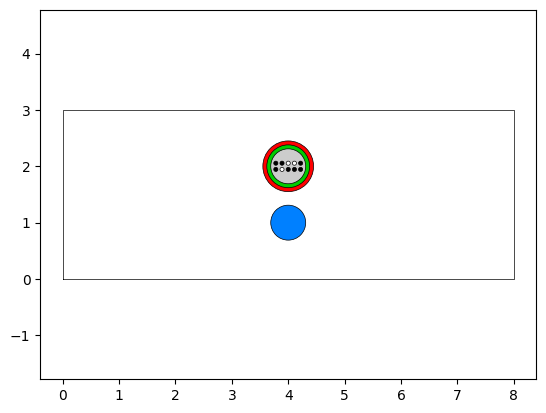

In [235]:
# step 4 / iteration 1: apply input u(0) to neuron

mon = Monitor(1,7);  cell.mon = mon
c = cell.input(1,c)
cell.plot(0,3)

-------------------------------------------------------------
iteration:  0 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .08  .28  .58  .81 -.04;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 0 , q: nan  (||q||=nan)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 1)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


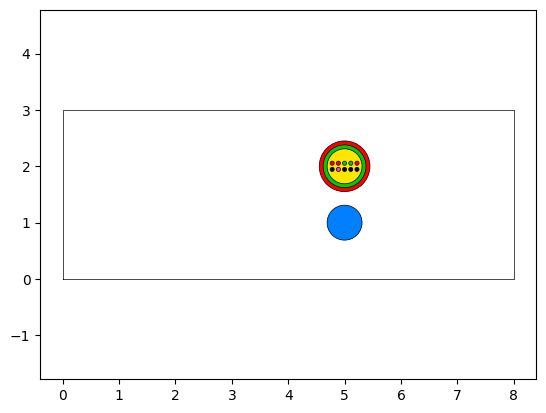

In [236]:
# step 5 / iteration 1: apply context c(0) to neuron

mon = Monitor(1,7);  cell.mon = mon
cell.context(c)
cell.plot(0,4)

-------------------------------------------------------------
iteration:  0 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: 1
   x: 0 (was: nan)
   y: 0 (was: nan)
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------
-------------------------------------------------------------
iteration:  0 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 1 , q: nan  (||q||=nan)
   l: [2, 1] , p: [1, 0] (||Q||=

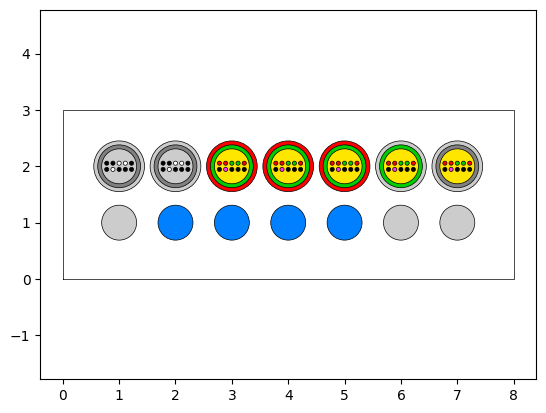

In [237]:
# all together now

    # step 0: create an inactive neuron

k = 0                        # cell index
g = [0,1,2,3]                # group indices
K = torch.tensor([[1,3,5,7,9],[3,4,5,6,7]])
P = torch.tensor([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])

mon = Monitor(1,7,verbose=1)
cell = Cell(mon,k,g,K,P)

c = [0,0,0,0,1,1,1,1,0,1]    # context
cell.plot()

    # step 1 / iteration 0: apply input u(t=0) to neuron

c = cell.input(1,c)
cell.plot(0,1)

    # step 2 / iteration 0: apply context c(t=0) to neuron

c = cell.context(c)
cell.plot(0,2)

    # step 3 / iteration 1: apply input u(t=1) to neuron

c = cell.input(1,c)
cell.plot(0,3)

    # step 4 / iteration 1: apply context c(t=1) to neuron

c = cell.context(c)
cell.plot(0,4)

    # step 5 / iteration 2: apply input u(t=2) to neuron

c = cell.input(0,c)
cell.plot(0,5)

    # step 6 / iteration 1: apply context c(t=2) to neuron

c = cell.context(c)
cell.plot(0,6)

